In [ ]:
! pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 -q
! pip install torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
fc = pd.read_csv('/content/drive/MyDrive/WiDS/new_data/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
y_ax = pd.read_excel('/content/drive/MyDrive/WiDS/new_data/TRAINING_SOLUTIONS.xlsx')
quantitative = pd.read_excel('/content/drive/MyDrive/WiDS/new_data/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
categorical = pd.read_excel('/content/drive/MyDrive/WiDS/new_data/TRAIN_CATEGORICAL_METADATA_new.xlsx')

In [ ]:
qc = np.hstack([quantitative, categorical.iloc[:,1:]])
df = pd.merge(fc,y_ax, on='participant_id', how='left')

## **Visualizing ADHD/Non-ADHD Male/Female Functional Connectomes**

In [ ]:
def reshape_values(data):
  df = data.copy()
  df[['row_index', 'col_index']] = df['position'].str.extract(r'(\d+)throw_(\d+)thcolumn').astype(int)
  df_reshaped_df = df.pivot(index='row_index', columns='col_index', values='value').fillna(0)
  df_reshaped_df.columns.name = None
  df_reshaped_df = df_reshaped_df.sort_index(axis=0).sort_index(axis=1)

  return df_reshaped_df

In [ ]:
adhd_male = reshape_values(fc.iloc[0].reset_index().iloc[1:,:].rename(columns={'index':'position', 0:'value'}))
adhd_female = reshape_values(fc.iloc[1].reset_index().iloc[1:,:].rename(columns={'index':'position', 1:'value'}))
control_male = reshape_values(fc.iloc[6].reset_index().iloc[1:,:].rename(columns={'index':'position', 6:'value'}))
control_female = reshape_values(fc.iloc[11].reset_index().iloc[1:,:].rename(columns={'index':'position', 11:'value'}))

<ipython-input-4-365111e3443c>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reshaped_df = df.pivot(index='row_index', columns='col_index', values='value').fillna(0)
<ipython-input-4-365111e3443c>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reshaped_df = df.pivot(index='row_index', columns='col_index', values='value').fillna(0)
<ipython-input-4-365111e3443c>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [ ]:
# Filling in lower diagonal for a better view
adhd_male_df = adhd_male.copy()
adhd_male_df.values[np.tril_indices(199, -1)] = adhd_male_df.values.T[np.tril_indices(199, -1)]

control_male_df = control_male.copy()
control_male_df.values[np.tril_indices(199, -1)] = control_male_df.values.T[np.tril_indices(199, -1)]

adhd_female_df = adhd_female.copy()
adhd_female_df.values[np.tril_indices(199, -1)] = adhd_female_df.values.T[np.tril_indices(199, -1)]

control_female_df = control_female.copy()
control_female_df.values[np.tril_indices(199, -1)] = control_female_df.values.T[np.tril_indices(199, -1)]


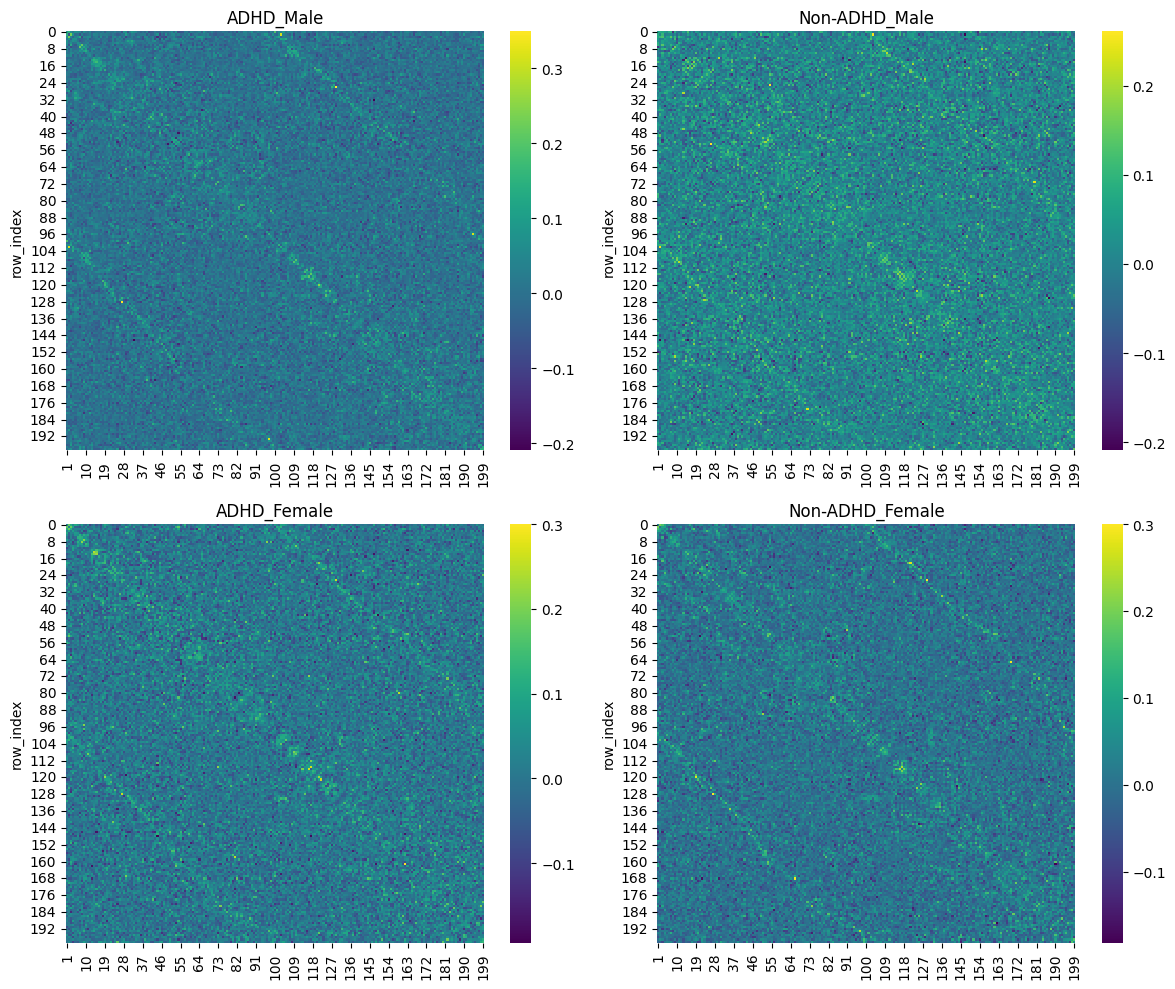

In [ ]:
dfs = [adhd_male_df, control_male_df, adhd_female_df, control_female_df]
titles = ["ADHD_Male", "Non-ADHD_Male", "ADHD_Female", "Non-ADHD_Female"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    sns.heatmap(dfs[i], ax=ax, cmap='viridis', cbar=True)
    ax.set_title(titles[i])

plt.savefig('/content/drive/MyDrive/WiDS/heatmaps.png')
plt.tight_layout()
plt.show()

## **GCN**

In [ ]:
def reshape_connectome_row(row):
    # Extract connectivity values
    connectome_data = row[1:]  # Assuming first three columns are participant_id, ADHD_Outcome, Sex_F
    connectome_data = connectome_data.dropna()  # Drop any missing values

    # Initialize adjacency matrix
    num_regions = 200  # Assuming 200 brain regions
    adj_matrix = np.zeros((num_regions, num_regions))

    # Populate adjacency matrix
    for col_name, value in connectome_data.items():
        match = re.match(r'(\d+)throw_(\d+)thcolumn', col_name)
        if match:
            i, j = int(match.group(1)), int(match.group(2))
            adj_matrix[i, j] = value
            adj_matrix[j, i] = value  # Ensure symmetry

    return adj_matrix


In [ ]:
adjacency_matrices = fc.apply(reshape_connectome_row, axis=1)

In [ ]:
data_list = []

for idx, adj in enumerate(adjacency_matrices):
    # Get non-zero indices
    edge_index = torch.tensor(np.array(adj).nonzero(), dtype=torch.long)
    edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float)

    # Create node features (e.g., zeros or other features if available)
    x = torch.zeros((adj.shape[0], 1), dtype=torch.float)

    # Extract labels
    y_adhd = torch.tensor(df.loc[idx, 'ADHD_Outcome'], dtype=torch.float)
    y_sex = torch.tensor(df.loc[idx, 'Sex_F'], dtype=torch.float)

    # Create Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=torch.stack([y_adhd, y_sex]))
    data_list.append(data)


In [ ]:
data

Data(x=[200, 1], edge_index=[2, 39006], edge_attr=[39006], y=[2])

In [ ]:
torch.save(data, '/content/drive/MyDrive/WiDS/fc_torch_data.pt')

In [ ]:
class GCNStream(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNStream, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return x

class MLPStream(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPStream, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class HybridModel(torch.nn.Module):
    def __init__(self, gcn_params, mlp_params, fusion_dim):
        super(HybridModel, self).__init__()
        self.gcn_stream = GCNStream(*gcn_params)
        self.mlp_stream = MLPStream(*mlp_params)
        self.classifier_adhd = torch.nn.Linear(fusion_dim, 1)
        self.classifier_sex = torch.nn.Linear(fusion_dim, 1)

    def forward(self, data, tabular_data):
        gcn_embedding = self.gcn_stream(data.x, data.edge_index, data.batch)
        mlp_embedding = self.mlp_stream(tabular_data)

        print("GCN embedding shape:", gcn_embedding.shape)
        print("MLP embedding shape:", mlp_embedding.shape)



        combined = torch.cat([gcn_embedding, mlp_embedding], dim=1)
        adhd_pred = torch.sigmoid(self.classifier_adhd(combined))
        sex_pred = torch.sigmoid(self.classifier_sex(combined))
        return adhd_pred, sex_pred

In [ ]:
qc = pd.concat([quantitative, categorical.iloc[:,1:]], axis=1)

In [ ]:
qc_tabular = qc.iloc[:,1:]

In [ ]:
qc_tabular.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [ ]:
# Assuming 'df' is your DataFrame containing tabular features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(qc_tabular)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=qc_tabular.columns)

# Convert the normalized data to a PyTorch tensor
tabular_tensor = torch.tensor(normalized_data, dtype=torch.float)

In [ ]:
# Assuming 'data' is your PyTorch Geometric Data object for the graph
# and 'tabular_tensor' is a PyTorch tensor of your normalized tabular data

# Instantiate your model with appropriate parameters
model = HybridModel(gcn_params=(1, 64, 32), mlp_params=(27, 64, 32), fusion_dim=64)

# Move model and data to the desired device (e.g., CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data = data.to(device)
tabular_tensor = tabular_tensor.to(device)

# Forward pass
adhd_pred, sex_pred = model(data, tabular_tensor)


GCN embedding shape: torch.Size([1, 32])
MLP embedding shape: torch.Size([1213, 32])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 1213 for tensor number 1 in the list.